In [ ]:
# -*- coding: utf-8 -*-
"""Enhanced Sectoral Bottom-Up Simulation with Comprehensive Testing"""

# import numpy as np
# import scipy
# from scipy.stats import nct, ncx2, kstest, norm
# from scipy.special import hyp1f1
# import matplotlib.pyplot as plt
# import pandas as pd
# from scipy.stats import kurtosis, pearsonr
# from typing import Tuple, List, Optional
# import logging



import math
import numpy as np
import scipy
from scipy.stats import nct, ncx2, kstest, norm
from scipy.special import hyp1f1
import sys
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import kurtosis, pearsonr
from typing import Tuple, List, Optional, Dict
import logging
from dataclasses import dataclass



#Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)


In [ ]:
class SectoralCIRSimulator:
    """Simulator for sectoral CIR model with default events"""

    def __init__(self, kappa: np.ndarray, theta: np.ndarray, sigma: np.ndarray,
                 n_firms: int, n_sectors: int):
        """
        Initialize the CIR simulator

        Parameters:
        -----------
        kappa : np.ndarray
            Mean reversion rates for each sector
        theta : np.ndarray
            Long-term means for each sector
        sigma : np.ndarray
            Volatilities for each sector
        n_firms : int
            Number of firms
        n_sectors : int
            Number of sectors
        """
        self.kappa = np.asarray(kappa)
        self.theta = np.asarray(theta)
        self.sigma = np.asarray(sigma)
        self.n_firms = n_firms
        self.n_sectors = n_sectors

        self._validate_parameters()
        self._check_feller_condition()

    def _validate_parameters(self):
        """Validate input parameters"""
        for param_name, param in zip(['kappa', 'theta', 'sigma'],
                                   [self.kappa, self.theta, self.sigma]):
            if len(param) != self.n_sectors:
                raise ValueError(f"{param_name} must have length {self.n_sectors}")
            if np.any(param <= 0):
                raise ValueError(f"{param_name} must be positive")

    def _check_feller_condition(self):
        """Check Feller condition for CIR process"""
        feller_ratio = (2 * self.kappa * self.theta) / (self.sigma ** 2)
        if np.all(feller_ratio >= 1):
            logger.info("Feller condition is satisfied for all sectors.")
        else:
            logger.warning("Feller condition is not satisfied for some sectors.")
            logger.warning(f"Feller ratios: {feller_ratio}")

    @staticmethod
    def lambda_max_generator(epsilon: float, y: float, theta: float, sigma: float,
                           kappa: float, max_attempts: int = 10, tol: float = 1e-8) -> float:
        """
        Compute H^*_epsilon such that P_y(sigma_H < tau) = G_y(H; H) <= epsilon.

        Implements Equation (11) using the closed-form in Equation (19).
        """
        def G_y(H: float) -> float:
            a = H / kappa
            b = 2 * kappa * theta / (sigma ** 2)
            z_y = 2 * kappa * y / (sigma ** 2)
            z_H = 2 * kappa * H / (sigma ** 2)
            num = hyp1f1(a, b, z_y)
            denom = hyp1f1(a, b, z_H)
            return num / denom

        def root_function(H: float) -> float:
            return G_y(H) - epsilon

        # Bracketing interval
        H_min = y + tol
        H_max = y + 10.0

        # Try to find root using numerical solver
        for attempt in range(max_attempts):
            try:
                H_star = scipy.optimize.toms748(root_function, H_min, H_max, xtol=tol)
                if root_function(H_star) <= 0:
                    return H_star
                else:
                    # Adjust if root function is still positive
                    H_star += 0.01
                    while root_function(H_star) > 0 and H_star < H_max + 5.0:
                        H_star += 0.01
                    return H_star
            except (ValueError, RuntimeError) as e:
                logger.debug(f"Attempt {attempt + 1} failed: {e}")
                H_max += 5.0

        # Fallback: grid search
        logger.warning("Root finding failed. Using fallback grid search.")
        H_vals = np.linspace(H_min, H_max + 50, 2000)
        for H in H_vals:
            if G_y(H) <= epsilon:
                return H

        raise RuntimeError(f"Unable to find H^*_epsilon for epsilon={epsilon}. Try expanding search space.")

    def simulate_default_events(self, T: float, W: np.ndarray, delta: np.ndarray,
                              idiosyncratic_factor: np.ndarray, epsilon: float,
                              low: float = 0.0, high: float = 1.0) -> Tuple[np.ndarray, ...]:
        """
        Simulate default events using Algorithm 3.2 from Giesecke 2013.

        Parameters:
        -----------
        T : float
            Time to maturity
        W : np.ndarray
            Sector weight matrix (n_firms × n_sectors)
        delta : np.ndarray
            Impact matrix (n_firms × n_sectors)
        idiosyncratic_factor : np.ndarray
            Firm-specific default factors
        epsilon : float
            Tolerance parameter
        low, high : float
            Uniform distribution bounds for loss marks

        Returns:
        --------
        events : np.ndarray
            Default event times
        marks : np.ndarray
            Loss marks for each default
        defaulter_idio_factor : np.ndarray
            Idiosyncratic factors of defaulters
        defaulter_sector_decomposition : np.ndarray
            Sector contributions for defaulters
        """
        # Precompute lambda benchmark
        lambda_benchmark = np.array([
            self.lambda_max_generator(epsilon, self.theta[i], self.theta[i],
                                    self.sigma[i], self.kappa[i])
            for i in range(self.n_sectors)
        ])

        t = 0.0
        lambda_t = self.theta.copy()
        gamma = self.theta.copy()

        events = []
        marks = []
        defaulter_idio_factor = []
        defaulter_sector_decomposition = []

        # Initialize active firms
        active_firms = np.arange(self.n_firms)

        while t < T and len(active_firms) > 0:
            # Compute lambda_max efficiently
            mask = lambda_t <= gamma
            lambda_max = np.where(mask, lambda_benchmark, lambda_t + lambda_benchmark - gamma)

            # Compute systemic and idiosyncratic parts
            systemic_part = np.sum(np.dot(W[active_firms], lambda_max))
            idiosyncratic_part = np.sum(idiosyncratic_factor[active_firms])
            H_epsilon = systemic_part + idiosyncratic_part

            # Generate next event time
            tau = np.random.exponential(1.0 / H_epsilon)
            t_proposed = t + tau

            if t_proposed >= T:
                break

            # Update lambda values
            exp_kappa_tau = np.exp(-self.kappa * tau)
            one_minus_exp = 1 - exp_kappa_tau
            c = self.sigma**2 * one_minus_exp / (4 * self.kappa)
            df = 4 * self.kappa * self.theta / (self.sigma**2)
            nc = 4 * self.kappa * lambda_t * exp_kappa_tau / (self.sigma**2 * one_minus_exp)

            lambda_proposedf = c * ncx2.rvs(df, nc, size=len(df))
            lambda_proposed = (np.sum(np.dot(W[active_firms], lambda_proposedf)) +
                             np.sum(idiosyncratic_factor[active_firms]))

            # Acceptance test
            acceptance_prob = min(lambda_proposed / H_epsilon, 1.0)

            if np.random.uniform() < acceptance_prob:
                # Accept proposed event
                t = t_proposed
                events.append(t)

                # Select defaulting firm
                probs = (idiosyncratic_factor[active_firms] +
                        np.dot(W[active_firms], lambda_proposedf)) / lambda_proposed
                probs = np.clip(probs, 0, None)  # Ensure non-negative
                probs /= np.sum(probs)  # Normalize

                selected_idx = np.random.choice(len(active_firms), p=probs)
                selected_defaulter = active_firms[selected_idx]

                # Update active firms
                active_firms = np.delete(active_firms, selected_idx)

                # Record default information
                defaulter_idio_factor.append(idiosyncratic_factor[selected_defaulter])
                defaulter_sector_decomposition.append(W[selected_defaulter])

                # Generate loss mark
                mark = np.random.uniform(low, high)


                # Update lambda_t with impact
                lambda_t = lambda_proposedf + delta[selected_defaulter] * mark
                marks.append(mark)
            else:
                # Reject event
                t = t_proposed
                lambda_t = lambda_proposedf

        return (np.array(events), np.array(marks),
                np.array(defaulter_idio_factor), np.array(defaulter_sector_decomposition))


In [ ]:
import numpy as np

def create_sector_weights(
    n_firms: int,
    n_sectors: int,
    concentration_type,

    balanced_mode='exact',
    balanced_concentration=100.0,
    dominant_sector: int = 0,
    dominant_share: float = 0.6,
    randomize_dominant: bool = True,

    concentration_strength: float = 100.0
) -> np.ndarray:
    """
    Create sector weight matrices with different concentration patterns.

    Parameters
    ----------
    n_firms : int
        Number of firms.
    n_sectors : int
        Number of sectors.
    concentration_type : str
        Pattern of sectoral exposure:
        - "concentrated": Each firm group is heavily concentrated in one sector.
        - "balanced": Each firm equally exposed across all sectors.
        - "mixed": One dominant sector, others equally less dominant.
    dominant_sector : int or None, optional
        Index (0-based) of the dominant sector for 'mixed' pattern.
        If None and randomize_dominant=True, chosen randomly.
    randomize_dominant : bool
        If True, randomize dominant sector assignments when relevant.

    Returns
    -------
    W : np.ndarray of shape (n_firms, n_sectors)
        Sector weight matrix (rows sum to 1).
    """

    if n_sectors < 1:
        raise ValueError("n_sectors must be >= 1")

    # --- Concentrated: assign groups of firms to different dominant sectors ---
    if concentration_type.lower() == "concentrated":
        if n_sectors < 1:
            raise ValueError("n_sectors must be >= 1")
        if not (0 < dominant_share < 1):
            raise ValueError("dominant_share must be in (0,1)")
        if not (0 <= dominant_sector < n_sectors):
            raise ValueError("dominant_sector index out of range")

        # target mean vector
        if n_sectors == 1:
            target = np.array([1.0])
        else:
            other_share = (1.0 - dominant_share) / (n_sectors - 1)
            target = np.full(n_sectors, other_share)
            target[dominant_sector] = dominant_share

        # alpha for Dirichlet (scale target by concentration_strength)
        alpha = target * concentration_strength

        # sample n_firms independent Dirichlet draws
        W = np.random.dirichlet(alpha, size=n_firms)
        #print(W[0:10])
    # --- Balanced: equal exposure across all sectors ---
    elif concentration_type.lower() == "balanced":
        if balanced_mode == 'exact':
            W = np.tile(np.ones(n_sectors)/n_sectors, (n_firms,1))
        elif balanced_mode == 'near':
            alpha = np.full(n_sectors, balanced_concentration)
            W = np.random.dirichlet(alpha, size=n_firms)
        elif balanced_mode == 'random':
            alpha = np.ones(n_sectors)  # or alpha=2 for moderate
            W = np.random.dirichlet(alpha, size=n_firms)
        else:
            raise ValueError("balanced_mode must be 'exact', 'near' or 'random'")
        #print(W[0:10])
    # --- Mixed: one dominant sector, others equal ---
    elif concentration_type.lower() == "mixed":
        if dominant_sector is None and randomize_dominant:
            dominant_sector = np.random.randint(0, n_sectors)
        elif dominant_sector is None:
            dominant_sector = 0  # fallback default

        alpha = np.full(n_sectors, 2.0)
        alpha[dominant_sector] = 3.0  # heavier weight to chosen sector
        W = np.random.dirichlet(alpha, size=n_firms)
        #print(W[0:10])
    else:
        raise ValueError("concentration_type must be 'concentrated', 'balanced', or 'mixed'")

    return W


# Alternative function if you want to generate all three types at once
def create_all_sector_weight_scenarios(n_firms: int, n_sectors: int, share: float) -> List[np.ndarray]:
    """
    Create all three concentration scenarios at once

    Returns:
    --------
    W_list : List[np.ndarray]
        List of weight matrices in order: [concentrated, balanced, mixed]
    """
    W_list = []

    # Concentrated: one dominant sector
    W_conc = create_sector_weights(n_firms, n_sectors, "concentrated", dominant_share= share)
    W_list.append(W_conc)

    # Balanced: equal weights
    W_bal = create_sector_weights(n_firms, n_sectors, "balanced")
    W_list.append(W_bal)

    # Mixed: one dominant, others equal
    W_mixed = create_sector_weights(n_firms, n_sectors, "mixed")
    W_list.append(W_mixed)

    #print(W_list)

    return W_list

def calculate_expected_shortfall(losses: np.ndarray, alpha: float = 0.95) -> float:
    """
    Calculate Expected Shortfall (CVaR) at confidence level alpha
    """
    # Calculate VaR (Value at Risk) at alpha level
    var = np.quantile(losses, alpha)

    # Expected Shortfall is the average of losses exceeding VaR
    tail_losses = losses[losses >= var]

    if len(tail_losses) > 0:
        es = np.mean(tail_losses)
    else:
        es = var  # Fallback if no losses exceed VaR

    return es

def plot_loss_distribution(losses: np.ndarray, label: str, ax: plt.Axes, bins: int = 10):
    """
    Plot loss distribution with smooth interpolation

    Parameters:
    -----------
    losses : np.ndarray
        Array of loss values
    label : str
        Label for the plot
    ax : plt.Axes
        Matplotlib axes object
    bins : int
        Number of histogram bins
    """
    # Get histogram data (without plotting)
    counts, bin_edges = np.histogram(losses, bins=bins, density=True)

    # Get bin centers
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Interpolation function
    f_interp = interp1d(bin_centers, counts, kind='cubic', fill_value="extrapolate")

    # New x-values for smooth curve
    x_smooth = np.linspace(bin_centers.min(), bin_centers.max(), 500)
    y_smooth = f_interp(x_smooth)

    # Plot histogram and interpolated curve
    ax.hist(losses, bins=50, density=True, alpha=0.4)
    ax.plot(x_smooth, y_smooth, label=label, linewidth=2)

    ax.set_xlabel('Loss')
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True, alpha=0.3)

In [ ]:
T = 1 # observation window (use consistently)

N_FIRMS = 1000
J = 3
NUM_TRIALS = 2500
theta_sector = np.random.uniform(0.001, 0.051, J) #np.array([0.1, 0.15, 0.2])  # 1-2% baseline intensity
kappa_sector = np.random.uniform(0.5, 1.5, J)      # Faster mean reversion
sigma_sector = np.minimum(np.sqrt(2*theta_sector*kappa_sector),np.random.uniform(0.0, 0.2, J))#np.random.uniform(0.02, 0.04, J)    # Lower volatility
idiosyncratic_factors = np.random.uniform(0.01,0.03,N_FIRMS)#0.01*np.ones(N_FIRMS)

#W_list = create_all_sector_weight_scenarios(N_FIRMS, J, 0.5)
#print(W_list)
config_names = ["Concentrated"]
# Option 2: Reduced impact]
#delta_list = [0.01 * W for W in W_list]


In [ ]:
dominant_sector_shares = [0.4, 0.5, 0.6, 0.7, 0.8]
c_values = [0.001, 0.002, 0.004, 0.008, 0.01, 0.05 ]   # <-- Try different levels of sector sensitivity

epsilon = 1 / NUM_TRIALS
ES_results = {}
EL_results = {}

for c in c_values:
    print(f'\n========== Testing for c = {c} ==========\n')
    ES_list = []
    EL_list = []

    for share in dominant_sector_shares:
        print(f'Concentration on sector 0: {share:.2f}')

        # Create sector weights for given concentration
        W_conc = create_sector_weights(N_FIRMS, J, "concentrated", dominant_share=share)
        delta_conc = [c * W for W in W_conc]

        # Initialize simulator
        simulator = SectoralCIRSimulator(kappa_sector, theta_sector, sigma_sector, N_FIRMS, J)

        losses = np.zeros(NUM_TRIALS)
        default_counts = np.zeros(NUM_TRIALS)

        # Run Monte Carlo trials
        for trial in range(NUM_TRIALS):
            events, marks, _, _ = simulator.simulate_default_events(
                T, W_conc, delta_conc, idiosyncratic_factors, epsilon
            )
            losses[trial] = np.sum(marks)
            default_counts[trial] = len(events)

        mean_loss = np.mean(losses)

        # Store Expected Shortfall and Expected Loss
        ES_val = calculate_expected_shortfall(losses, 0.95)
        ES_list.append(ES_val)
        EL_list.append(mean_loss)

        print(f'  ES (95%): {ES_val:.4f}')
        print(f'  Mean Loss: {mean_loss:.4f}\n')

    # Store results for this c
    ES_results[c] = ES_list
    EL_results[c] = EL_list


========== Testing for c = 0.001 ==========

Concentration on sector 0: 0.40
  ES (95%): 36.6772
  Mean Loss: 27.0476

Concentration on sector 0: 0.50
  ES (95%): 36.1666
  Mean Loss: 26.5145

Concentration on sector 0: 0.60
  ES (95%): 35.8326
  Mean Loss: 26.0137

Concentration on sector 0: 0.70
  ES (95%): 35.8251
  Mean Loss: 25.6783

Concentration on sector 0: 0.80
  ES (95%): 35.3035
  Mean Loss: 25.2483


========== Testing for c = 0.002 ==========

Concentration on sector 0: 0.40
  ES (95%): 39.7452
  Mean Loss: 28.9562

Concentration on sector 0: 0.50
  ES (95%): 39.3487
  Mean Loss: 28.1341

Concentration on sector 0: 0.60
  ES (95%): 39.2906
  Mean Loss: 27.8122

Concentration on sector 0: 0.70
  ES (95%): 40.1643
  Mean Loss: 28.2251

Concentration on sector 0: 0.80
  ES (95%): 40.2193
  Mean Loss: 28.5653


========== Testing for c = 0.004 ==========

Concentration on sector 0: 0.40
  ES (95%): 46.2051
  Mean Loss: 32.8483

Concentration on sector 0: 0.50
  ES (95%): 46.1

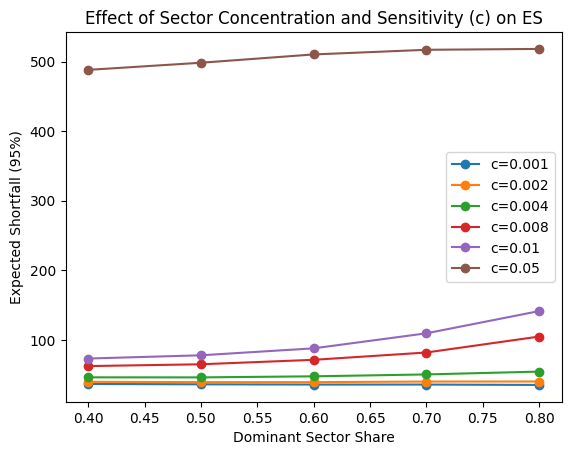

In [ ]:
for c in c_values:
    plt.plot(dominant_sector_shares, ES_results[c],marker='o', label=f'c={c}')
plt.xlabel("Dominant Sector Share")
plt.ylabel("Expected Shortfall (95%)")
plt.legend()
plt.title("Effect of Sector Concentration and Sensitivity (c) on ES")
plt.show()

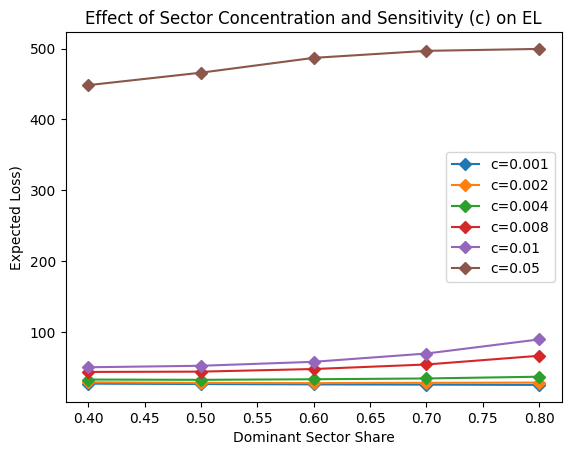

In [ ]:
for c in c_values:
    plt.plot(dominant_sector_shares, EL_results[c],marker='D', label=f'c={c}')
plt.xlabel("Dominant Sector Share")
plt.ylabel("Expected Loss)")
plt.legend()
plt.title("Effect of Sector Concentration and Sensitivity (c) on EL")
plt.show()